# Setup dataset

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

os.chdir('/home/ubuntu/Thesis-KNMI-FoggyGAN/')
df_test = pd.read_pickle('data/raw/test_annotations.pkl')

keep = [0, 20, 21, 30, 31]
df_test = df_test[df_test.day_phase.isin(keep)]
df_test = df_test[df_test.label != 'Cannot Say'] # Drop images with label cannot say

mapping = {'No Fog':0, 'Fog':1}
y_true = df_test['label'].map(mapping)

# Prepare model

In [82]:
from keras.models import load_model

model = load_model('models/new/model4.h5')
img_size = (256, 256)
last_conv_layer_name = 'conv2d_5'

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 247, 247, 12)      3612      
_________________________________________________________________
dropout_4 (Dropout)          (None, 247, 247, 12)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 123, 123, 12)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 119, 119, 8)       2408      
_________________________________________________________________
dropout_5 (Dropout)          (None, 119, 119, 8)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 59, 59, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 55, 55, 8)        

# Select image

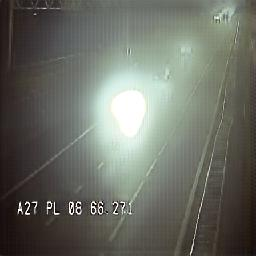

In [96]:
# fname = df_test[df_test.label == 'Fog'].sample(1, random_state=25)['filename'].values[0]
# datadir = 'data/raw/test'
datadir = 'data/processed/generated_images4'
fname = os.listdir(datadir)[10] # Sample random filename

img_path = os.path.join(datadir, fname)



display(Image(img_path))

# The Grad-CAM algorithm

In [97]:
def get_img_array(img_path, size):
    # `img` is a PIL image
    img = keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
    # `array` is a float32 Numpy array of shape (256, 256, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    array = array/255 #rescale
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Predicted class:  [[1]]


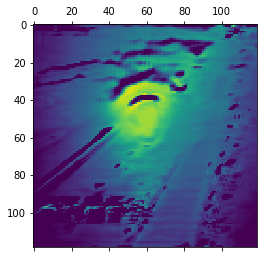

In [98]:
img_array = get_img_array(img_path, size=(256, 256))

# Remove last layer's softmax
model.layers[-1].activation = None

probas = model.predict(img_array)
predicted_class = (probas > 0.5).astype('int32')
print('Predicted class: ', str(predicted_class))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Create visualization

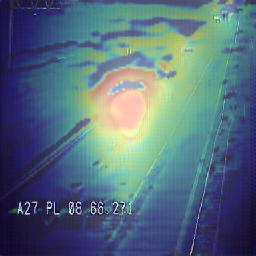

In [99]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)